In [1]:
import os
print(os.listdir("../input"))
print(os.listdir("../input/flowershd5dataset/flowers-hd5/data/flowers/"))
print(os.listdir("../input/flowershd5words/"))
print(os.listdir("../input/checkpoints/"))
hdf5_fpath = "../input/flowershd5dataset/flowers-hd5/data/flowers/flowers.hdf5"

['checkpoints', 'flowershd5words', 'flowershd5dataset']
['flowers.hdf5']
['flowers.hdf5.words']
['source_flowers_only_nn_labels.pl', 'source_flowers_only_nn.pl', 'gen_75.pth', 'source_flowers_only_nn_data.pl', 'source_flowers_only_nn_embeddings.pl', 'disc_75.pth']


In [3]:
#view contents in HDF5 files
f = h5py.File(hdf5_fpath)

#1. to know the categories in hdf5 file
print(list(f))
print("\nNo. of items in test = ",len(list(f['test'])))
print("\nNo. of items in train = ",len(list(f['train'])))
print("\nNo. of items in valid = ",len(list(f['valid'])))

#2. see what data is stored in each category
#print("\n\ntest = \n",list(f['test']))

#print("\n\ntrain = \n",list(f['train']))

#print("\n\nvalid = \n",list(f['valid']))

['test', 'train', 'valid']

No. of items in test =  5775

No. of items in train =  29390

No. of items in valid =  5780


loading discriminator from ../input/checkpoints/disc_75.pth
loading generator from ../input/checkpoints/gen_75.pth
***Calling Nearest Neighbour***
start loading data for NN test ../input/checkpoints/source_flowers_only_nn_data.pl
finish loading data for NN test
***Calling CCA_Test***
*** Calling test() ***


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:827: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:828: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:832: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


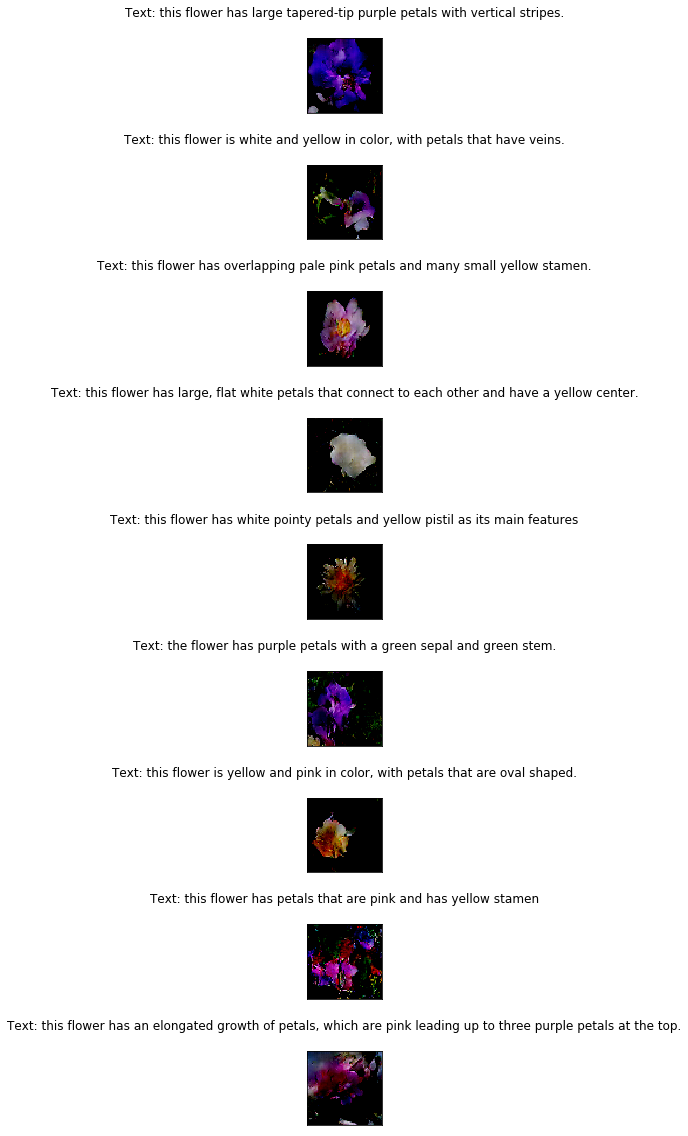

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:827: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:828: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:832: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


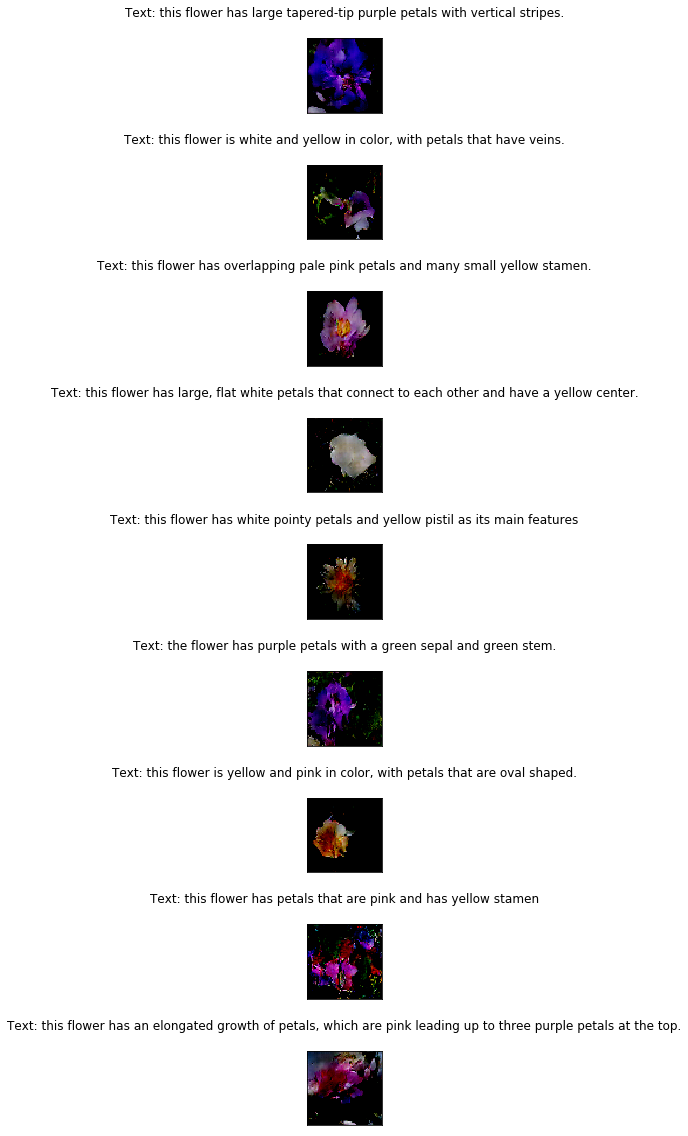


combined text:  0 original sentence:  this flower has large tapered-tip purple petals with vertical stripes.
 nn_sentences:  ['a flower with very large, broad white petals and red and green central stamen\n', 'a flower with very large, broad white petals and red and green central stamen\n']

combined text:  1 original sentence:  this flower is white and yellow in color, with petals that have veins.
 nn_sentences:  ['this flower is white and pink in color, with petals that are spotted.\n', 'this flower is white and pink in color, with petals that are spotted.\n']

combined text:  2 original sentence:  this flower has overlapping pale pink petals and many small yellow stamen.
 nn_sentences:  ['a flower with very large, broad white petals and red and green central stamen\n', 'this flower has petals that are white and is bell shaped\n']

combined text:  3 original sentence:  this flower has large, flat white petals that connect to each other and have a yellow center.
 nn_sentences:  ['a f

In [4]:
IGNORE_WORDS = ['flower', 'and', 'this', 'has', 'this', 'has', 'are', 'with', 'a', 'the', 'that', 'in', 'is', 'of',
                'on', 'as', ]
COLORS = ["yellow", "white", "pink", "purple", "red", "green", "orange", "blue", "brown", "black", "maroon", "gold",
          "gray", "lime", "grey", "lavender", "magenta", "violet", "rose", "lilac", "peach", "charcoal"]


class CCA_Test:
    def __init__(self, dataset, max_words=1000, ignore_words=False):
        self.max_words = max_words
        if dataset == 'flowers_only':
            source_words_f = open('../input/flowershd5words/flowers.hdf5.words', 'r')
            target_words_f = open('../input/flowershd5words/flowers.hdf5.words', 'r')
        self.target_words = []
        self.source_words = []
        for line in source_words_f:
            word = line.split(',')[0]
            if not ignore_words or word not in IGNORE_WORDS:
                self.source_words.append(word)
        for line in target_words_f:
            word = line.split(',')[0]
            if not ignore_words or word not in IGNORE_WORDS:
                self.target_words.append(word)
        # Take only the most common words
        self.source_words = self.source_words[:max_words]
        self.target_words = self.target_words[:max_words]
        self.s_to_i = {k: v for v, k in enumerate(self.source_words)}
        self.t_to_i = {k: v for v, k in enumerate(self.target_words)}

    def sentences_to_one_hot_vector(self, sentences, source=True):
        if source:
            words = self.source_words
            word_to_index = self.s_to_i
        else:
            words = self.target_words
            word_to_index = self.t_to_i
        mat = np.zeros((len(sentences), len(words)))
        for i, sentence in enumerate(sentences):
            sentence = ''.join(c for c in sentence if c not in '"();:!@#$,.\n')
            sentence = sentence.split(' ')
            for word in sentence:
                if word in word_to_index:
                    mat[i][word_to_index[word]] = 1
        return mat

    def run(self, source_sentences, target_sentences, embedding=False):
        print('---begin CCA RUN---')
        print('source len {}, target len {}'.format(len(source_sentences), len(target_sentences)))
        min_size = min(len(source_sentences), len(target_sentences))
        if embedding:
            X = np.asmatrix(source_sentences[:min_size])
            Y = np.asmatrix(target_sentences[:min_size])
        else:
            X = self.sentences_to_one_hot_vector(source_sentences[:min_size], True)
            Y = self.sentences_to_one_hot_vector(target_sentences[:min_size], False)
        cca = rcca.CCA(kernelcca=False, reg=0.01, numCC=500)
        cca.train([X, Y])
        print('more than {} {}'.format(0.6, np.sum(cca.cancorrs > 0.6)))
        print('more than {} {}'.format(0.5, np.sum(cca.cancorrs > 0.5)))
        print('more than {} {}'.format(0.4, np.sum(cca.cancorrs > 0.4)))
        return float(np.average(cca.cancorrs)), float(np.sum(cca.cancorrs > 0.6))

class NearestNeighbor:
    def __init__(self, dataset, source, cuda, ngf):
        self.dataset = dataset
        data = None
        representation = None
        labels = []
        embeddings = []
        path = '../input/checkpoints/'
        data_path = path + 'source_{}_nn_data.pl'.format(source)
        labels_path = path + 'source_{}_nn_labels.pl'.format(source)
        nbrs_path = path + 'source_{}_nn.pl'.format(source)
        embeddings_path = path + 'source_{}_nn_embeddings.pl'.format(source)
        self.model = gan_factory.generator_factory('vae', ngf, False)
        if cuda:
            self.model = self.model.cuda()
        #self.model.load_state_dict(torch.load('./checkpoints/flowers_autoencoder/gen.pth'))

        if os.path.exists(data_path):
            print('start loading data for NN test {}'.format(data_path))
            data = pickle.load(open(data_path, 'rb'))
            labels = pickle.load(open(labels_path, 'rb'))
            nbrs = pickle.load(open(nbrs_path, 'rb'))
            embeddings = pickle.load(open(embeddings_path, 'rb'))
        else:
            print('start creating data for NN test {}'.format(data_path))
            for i, sample in enumerate(dataset):
                #print("**** iter i = ",i)
                if data is None:
                    data = sample['right_images'].numpy()
                    data_var = Variable(sample['right_images'].float(), volatile=True)
                    if cuda:
                        data_var = data_var.cuda()
                    representation = self.model.encoder_only(data_var).data.cpu().numpy()
                    labels = sample['txt']
                    embeddings = sample['right_embed']
                else:
                    data = np.append(data, sample['right_images'].numpy(), axis=0)
                    data_var = Variable(sample['right_images'].float(), volatile=True)
                    if cuda:
                        data_var = data_var.cuda()
                    representation = np.append(representation, self.model.encoder_only(data_var).data.cpu().numpy(),
                                               axis=0)
                    labels += sample['txt']
                    embeddings = np.append(embeddings, sample['right_embed'].numpy(), axis=0)
            nbrs = NearestNeighbors(n_neighbors=2, algorithm='ball_tree').fit(representation.reshape(-1, 228))
            pickle.dump(data, open(data_path, 'wb'))
            pickle.dump(labels, open(labels_path, 'wb'))
            pickle.dump(nbrs, open(nbrs_path, 'wb'))
            pickle.dump(embeddings, open(embeddings_path, 'wb'))
        print('finish loading data for NN test')
        self.data = data
        self.labels = labels
        self.nbrs = nbrs
        self.embeddings = embeddings

    def get_text(self, samples, limit=-1):
        text_results, _, _ = self.get_text_and_images_and_embedding(samples, limit)
        return text_results

    def get_text_and_images(self, samples, limit):
        text_results, image_results, _ = self.get_text_and_images_and_embedding(samples, limit)
        return text_results, image_results

    def get_text_and_images_and_embedding(self, samples, limit=-1):
        samples_embedding = self.model.encoder_only(samples).data.cpu().numpy().reshape(-1, 228)
        if limit != -1:
            samples_embedding = samples_embedding[:limit]
        distances, indices = self.nbrs.kneighbors(samples_embedding)
        text_results = [self.labels[index] for index in indices[:, 0]]
        image_results = [self.data[index] for index in indices[:, 0]]
        embedding_results = [self.embeddings[index] for index in indices[:, 0]]
        return text_results, image_results, embedding_results
    

class Text2ImageDataset(Dataset):

    def __init__(self, datasetFile, transform=None, split=0):
        self.datasetFile = datasetFile
        self.transform = transform
        self.dataset = None
        self.dataset_keys = None
        self.split = 'train' if split == 0 else 'valid' if split == 1 else 'test'
        self.h5py2int = lambda x: int(np.array(x))

    def __len__(self):
        f = h5py.File(self.datasetFile, 'r')
        self.dataset_keys = [str(k) for k in f[self.split].keys()]
        length = len(f[self.split])
        f.close()

        return length

    def __getitem__(self, idx):
        if self.dataset is None:
            self.dataset = h5py.File(self.datasetFile, mode='r')
            self.dataset_keys = [str(k) for k in self.dataset[self.split].keys()]

        example_name = self.dataset_keys[idx]
        example = self.dataset[self.split][example_name]

        return example

    def find_wrong_image(self, category):
        idx = np.random.randint(len(self.dataset_keys))
        example_name = self.dataset_keys[idx]
        example = self.dataset[self.split][example_name]
        _category = example['class']

        if _category != category:
            return example['img']

        return self.find_wrong_image(category)

    def find_inter_embed(self):
        idx = np.random.randint(len(self.dataset_keys))
        example_name = self.dataset_keys[idx]
        example = self.dataset[self.split][example_name]
        return example['embeddings']



class Concat_embed(nn.Module):
    def __init__(self, embed_dim, projected_embed_dim):
        super(Concat_embed, self).__init__()
        self.projection = nn.Sequential(nn.Linear(in_features=embed_dim, out_features=projected_embed_dim),
                                        nn.BatchNorm1d(num_features=projected_embed_dim),
                                        nn.LeakyReLU(negative_slope=0.2, inplace=True))

    def forward(self, inp, embed):
        projected_embed = self.projection(embed)
        replicated_embed = projected_embed.repeat(4, 4, 1, 1).permute(2, 3, 0, 1)
        hidden_concat = torch.cat([inp, replicated_embed], 1)

        return hidden_concat

class Utils(object):
    def __init__(self, cuda):
        self.is_cuda = cuda

    def cuda(self, variable):
        return variable.cuda() if self.is_cuda else variable

    @staticmethod
    def smooth_label(tensor, offset):
        return tensor + offset

    @staticmethod
    def save_checkpoint(netD, netG, dir_path, epoch):
        path = dir_path #os.path.join(dir_path, subdir_path)
        if not os.path.exists(path):
            os.makedirs(path)

        torch.save(netD.state_dict(), '{0}/disc_{1}.pth'.format(path, epoch))
        torch.save(netG.state_dict(), '{0}/gen_{1}.pth'.format(path, epoch))
        
    @staticmethod
    def weights_init(m):
        classname = m.__class__.__name__
        if classname.find('Conv') != -1:
            m.weight.data.normal_(0.0, 0.02)
        elif classname.find('BatchNorm') != -1:
            m.weight.data.normal_(1.0, 0.02)
            m.bias.data.fill_(0)


class vanilla_generator(nn.Module):
    def __init__(self):
        super(vanilla_generator, self).__init__()
        self.image_size = 64
        self.num_channels = 3
        self.noise_dim = 100
        self.ngf = 64

        # based on: https://github.com/pytorch/examples/blob/master/dcgan/main.py
        self.netG = nn.Sequential(
            nn.ConvTranspose2d(self.noise_dim, self.ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(self.ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(self.ngf * 8, self.ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(self.ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(self.ngf * 4, self.ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(self.ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(self.ngf * 2,self.ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(self.ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d(self.ngf, self.num_channels, 4, 2, 1, bias=False),
            nn.Tanh()
             # state size. (num_channels) x 64 x 64
            )

    def forward(self, z):
        return self.netG(z)


class vanilla_discriminator(nn.Module):
    def __init__(self):
        super(vanilla_discriminator, self).__init__()
        self.image_size = 64
        self.num_channels = 3
        self.ndf = 64

        self.B_dim = 128
        self.C_dim = 16

        self.netD_1 = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(self.num_channels, self.ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(self.ndf, self.ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(self.ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(self.ndf * 2, self.ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(self.ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(self.ndf * 4, self.ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(self.ndf * 8),
            nn.LeakyReLU(0.2, inplace=True)
        )

        self.netD_2 = nn.Sequential(
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(self.ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
            )

    def forward(self, inp):
        x_intermediate = self.netD_1(inp)
        output =  self.netD_2(x_intermediate)
        return output.view(-1, 1).squeeze(1), x_intermediate


class vae_encoder_generator(nn.Module):
    def __init__(self, ngf):
        super(vae_encoder_generator, self).__init__()
        self.vae_encoder = vae_encoder(ngf)
        self.vae_generator = vae_generator(ngf)

    def forward(self, inp):
        x = self.vae_encoder(inp)
        x = self.vae_generator(x)
        return x

    def generator_only(self, latent):
        return self.vae_generator(latent)

    def encoder_only(self, inp):
        return self.vae_encoder(inp.cuda())


class vae_generator(nn.Module):
    def __init__(self, ngf):
        super(vae_generator, self).__init__()
        self.image_size = 64
        self.num_channels = 3
        self.noise_dim = 100
        self.embed_dim = 1024
        self.projected_embed_dim = 128
        self.latent_dim = self.noise_dim + self.projected_embed_dim
        self.ngf = ngf

        # self.projection = nn.Sequential(nn.Linear(in_features=self.embed_dim, out_features=self.projected_embed_dim),
        #     nn.BatchNorm1d(num_features=self.projected_embed_dim), nn.LeakyReLU(negative_slope=0.2, inplace=True))

        # based on: https://github.com/pytorch/examples/blob/master/dcgan/main.py
        self.netG = nn.Sequential(
            nn.ConvTranspose2d(self.latent_dim, self.ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(self.ngf * 8),
            nn.ReLU(True), # state size. (ngf*8) x 4 x 4

            nn.ConvTranspose2d(self.ngf * 8, self.ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(self.ngf * 4),
            nn.ReLU(True), # state size. (ngf*4) x 8 x 8

            nn.ConvTranspose2d(self.ngf * 4, self.ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(self.ngf * 2),
            nn.ReLU(True), # state size. (ngf*2) x 16 x 16

            nn.ConvTranspose2d(self.ngf * 2, self.ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(self.ngf),
            nn.ReLU(True),

            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d(self.ngf, self.num_channels, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (num_channels) x 64 x 64
        )

    def forward(self, latent_vector):
        # projected_embed = self.projection(embed_vector).unsqueeze(2).unsqueeze(3)
        # latent_vector = torch.cat([projected_embed, z], 1)
        latent_vector = latent_vector.view(-1, self.latent_dim, 1, 1)
        #print("**** latent_vector is cuda = ",latent_vector.cpu().is_cuda)
        output = self.netG(latent_vector.cpu())

        return output


class vae_encoder(nn.Module):
    def __init__(self, ngf):
        super(vae_encoder, self).__init__()
        self.image_size = 64
        self.num_channels = 3
        self.embed_dim = 1024
        self.noise_dim = 100
        self.projected_embed_dim = 128
        self.latent_dim = self.noise_dim + self.projected_embed_dim
        self.ngf = ngf

        self.projection = nn.Sequential(nn.Linear(in_features=self.embed_dim, out_features=self.projected_embed_dim),
            nn.BatchNorm1d(num_features=self.projected_embed_dim), nn.LeakyReLU(negative_slope=0.2, inplace=True))

        # based on: https://github.com/pytorch/examples/blob/master/dcgan/main.py
        self.netE = nn.Sequential(
            # state size. (num_channels) x 64 x 64
            nn.Conv2d(self.num_channels, self.ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(self.ngf),
            nn.ReLU(True),

            # state size. (ngf) x 32 x 32
            nn.Conv2d(self.ngf, self.ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(self.ngf * 2),
            nn.ReLU(True),

            # state size. (ngf*2) x 16 x 16
            nn.Conv2d(self.ngf * 2, self.ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(self.ngf * 4),
            nn.ReLU(True),

            # state size. (ngf*4) x 8 x 8
            nn.Conv2d(self.ngf * 4, self.ngf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(self.ngf * 8),
            nn.ReLU(True),

            # state size. (ngf*8) x 4 x 4
            nn.Conv2d(self.ngf * 8, self.latent_dim, 4, 1, 0, bias=False),
            nn.Tanh()
        )

    def forward(self, images):
        output = self.netE(images)
        #print(output.is_cuda)
        return output


class vae_discriminator(nn.Module):
    def __init__(self, remove_noise):
        super(discriminator, self).__init__()
        self.image_size = 64
        self.num_channels = 128
        self.embed_dim = 1024
        if remove_noise:
            self.projected_embed_dim = 228
            self.noise_dim = 0
        else:
            self.projected_embed_dim = 128
            self.noise_dim = 100
        self.B_dim = 128
        self.C_dim = 16
        self.minibatch_discriminator = minibatch_discriminator(self.num_channels, self.B_dim, self.C_dim)
        #
        self.netD_1 = nn.Sequential(
            nn.Linear(self.projected_embed_dim + self.noise_dim, 228),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(228, 128),
            nn.LeakyReLU(0.2, inplace=True),
        )

        self.netD_2 = nn.Sequential(
            nn.Linear(128 + self.B_dim, 1),
            nn.Sigmoid()
        )

    def forward(self, inp):
        x = inp.view(-1, self.projected_embed_dim + self.noise_dim)
        x = self.netD_1(x)
        x = self.minibatch_discriminator(x)
        x = self.netD_2(x)

        return x.view(-1)


class generator(nn.Module):
    def __init__(self, remove_noise, variational):
        super(generator, self).__init__()
        self.image_size = 64
        self.num_channels = 3
        self.embed_dim = 1024
        self.remove_noise = remove_noise
        if remove_noise:
            self.noise_dim = 0
            self.projected_embed_dim = 228
        else:
            self.noise_dim = 100
            self.projected_embed_dim = 128
        self.latent_dim = self.noise_dim + self.projected_embed_dim
        self.ngf = 64
        self.variational = variational
        self.mu = None
        self.sd = None

        self.projection = nn.Sequential(nn.Linear(in_features=self.embed_dim, out_features=self.projected_embed_dim),
            nn.BatchNorm1d(num_features=self.projected_embed_dim), nn.LeakyReLU(negative_slope=0.2, inplace=True))

        if variational:
            self.en_mu = nn.Conv2d(self.projected_embed_dim, self.projected_embed_dim, 1, 1, 0)
            self.en_sigma = nn.Conv2d(self.projected_embed_dim, self.projected_embed_dim, 1, 1, 0)
            self.softplus = nn.Softplus()
            self.en_mu.weight.data.normal_(0, 0.002)
            self.en_mu.bias.data.normal_(0, 0.002)
            self.en_sigma.weight.data.normal_(0, 0.002)
            self.en_sigma.bias.data.normal_(0, 0.002)

        # based on: https://github.com/pytorch/examples/blob/master/dcgan/main.py
        self.netG = nn.Sequential(nn.ConvTranspose2d(self.latent_dim, self.ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(self.ngf * 8), nn.ReLU(True), # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(self.ngf * 8, self.ngf * 4, 4, 2, 1, bias=False), nn.BatchNorm2d(self.ngf * 4),
            nn.ReLU(True), # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(self.ngf * 4, self.ngf * 2, 4, 2, 1, bias=False), nn.BatchNorm2d(self.ngf * 2),
            nn.ReLU(True), # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(self.ngf * 2, self.ngf, 4, 2, 1, bias=False), nn.BatchNorm2d(self.ngf), nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d(self.ngf, self.num_channels, 4, 2, 1, bias=False), nn.Tanh()
            # state size. (num_channels) x 64 x 64
        )

    def forward(self, embed_vector, z, noise):
        return self.netG(self.encoder_only(embed_vector, z, noise))

    def encoder_only(self, embed_vector, z, noise):
        projected_embed = self.projection(embed_vector).unsqueeze(2).unsqueeze(3)
        if self.variational:
            self.mu = self.en_mu(projected_embed)
            self.sd = self.softplus(self.en_sigma(projected_embed))
            projected_embed = self.mu + self.sd.mul(noise)
        if self.remove_noise:
            latent_vector = projected_embed
        else:
            latent_vector = torch.cat([projected_embed, z], 1)
        return latent_vector

    def generator_only(self, latent_vector):
        return self.netG(latent_vector)


class discriminator(nn.Module):
    def __init__(self, remove_noise):
        super(discriminator, self).__init__()
        self.image_size = 64
        self.num_channels = 3
        self.embed_dim = 1024
        if remove_noise:
            self.projected_embed_dim = 228
        else:
            self.projected_embed_dim = 128
        self.ndf = 64
        self.B_dim = 128
        self.C_dim = 16

        self.netD_1 = nn.Sequential(# input is (nc) x 64 x 64
            nn.Conv2d(self.num_channels, self.ndf, 4, 2, 1, bias=False), nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(self.ndf, self.ndf * 2, 4, 2, 1, bias=False), nn.BatchNorm2d(self.ndf * 2),
            nn.LeakyReLU(0.2, inplace=True), # state size. (ndf*2) x 16 x 16
            nn.Conv2d(self.ndf * 2, self.ndf * 4, 4, 2, 1, bias=False), nn.BatchNorm2d(self.ndf * 4),
            nn.LeakyReLU(0.2, inplace=True), # state size. (ndf*4) x 8 x 8
            nn.Conv2d(self.ndf * 4, self.ndf * 8, 4, 2, 1, bias=False), nn.BatchNorm2d(self.ndf * 8),
            nn.LeakyReLU(0.2, inplace=True), )

        self.projector = Concat_embed(self.embed_dim, self.projected_embed_dim)

        self.netD_2 = nn.Sequential(# state size. (ndf*8) x 4 x 4
            nn.Conv2d(self.ndf * 8 + self.projected_embed_dim, 1, 4, 1, 0, bias=False), nn.Sigmoid())

    def forward(self, inp, embed):
        x_intermediate = self.netD_1(inp)
        x = self.projector(x_intermediate, embed)
        x = self.netD_2(x)

        return x.view(-1, 1).squeeze(1), x_intermediate

class gan_factory(object):
    @staticmethod
    def generator_factory(type, ngf, remove_noise, variational=False):
        if type == 'gan':
            return generator(remove_noise, variational)
        elif type == 'vanilla_gan':
            return vanilla_generator()
        elif type == 'vae':
            return vae_encoder_generator(ngf)

    @staticmethod
    def discriminator_factory(type, remove_noise):
        if type == 'gan':
            return discriminator(remove_noise)
        elif type == 'vanilla_gan':
            return vanilla_discriminator()
        elif type == 'vae':
            return vae_discriminator(remove_noise)


class Trainer(object):
    def __init__(self, type, dataset, split, lr, diter, vis_screen, save_path, l1_coef, l2_coef, pre_trained_gen,
                 pre_trained_disc, batch_size, num_workers, epochs, args, params_search=False):
        self.config = args
        self.cuda = torch.cuda.is_available()

        self.generator = gan_factory.generator_factory(type, args.ngf, args.remove_noise_2, args.variational)
        self.discriminator = gan_factory.discriminator_factory(type, args.remove_noise_2)

        self.target_generator = gan_factory.generator_factory(args.target_type, args.ngf, args.remove_noise_2)
        
        if self.cuda:
            self.generator = self.generator.cuda()
            self.discriminator = self.discriminator.cuda()

        if pre_trained_disc:
            print('loading {} from {}'.format('discriminator', pre_trained_disc))
            self.discriminator.load_state_dict(torch.load(pre_trained_disc))
        else:
            if not params_search:
                print('creating fresh params for {}'.format('discriminator'))
            self.discriminator.apply(Utils.weights_init)

        if pre_trained_gen:
            print('loading {} from {}'.format('generator', pre_trained_gen))
            self.generator.load_state_dict(torch.load(pre_trained_gen))
        else:
            if not params_search:
                print('creating fresh params for {}'.format('generator'))
            self.generator.apply(Utils.weights_init)

        if dataset == 'flowers_only':
            self.dataset = Text2ImageDataset(self.config.flowers_dataset_path, split=0)
            self.target_dataset = Text2ImageDataset(self.config.flowers_dataset_path, split=2)
        else:
            print('Dataset not supported, please select either birds, flowers or flowers_only.')
            exit()

        self.noise_dim = 100
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.lr = lr
        self.beta1 = 0.5
        self.num_epochs = epochs
        self.DITER = diter

        self.l1_coef = l1_coef
        self.l2_coef = l2_coef

        self.data_loader = DataLoader(self.dataset, batch_size=self.batch_size, shuffle=True,
                                      num_workers=self.num_workers)
        self.target_data_loader = DataLoader(self.target_dataset, batch_size=self.batch_size, shuffle=True,
                                             num_workers=self.num_workers)

        self.optimD = torch.optim.Adam(self.discriminator.parameters(), lr=self.lr, betas=(self.beta1, 0.999))
        self.optimG = torch.optim.Adam(self.generator.parameters(), lr=self.lr, betas=(self.beta1, 0.999))

        self.save_path = save_path
        self.type = type
        # self.h_el = args.h_el
        self.args = args
        if not params_search:
            self.checkpoints_path = 'checkpoints/{}'.format(vis_screen)
            if not os.path.exists(self.checkpoints_path):
                os.makedirs(self.checkpoints_path)
            print("***Calling Nearest Neighbour***")
            self.nn = NearestNeighbor(self.target_data_loader, dataset, self.cuda, args.ngf)
            print("***Calling CCA_Test***")
            self.cca = CCA_Test(dataset, max_words=1000, ignore_words=False)
        self.params_search = params_search
        
    def train(self, cls=False):
        print("*** Inside train() func ***")
        #if self.type == 'wgan':
            #self._train_wgan(cls)
        if self.type == 'gan':
            self._train_gan(cls)
        #elif self.type == 'vanilla_wgan':
            #self._train_vanilla_wgan()
        #elif self.type == 'vanilla_gan':
            #self._train_vanilla_gan()
        
    def _train_gan(self, cls):
        print("*** Inside _train_gan() func ***")
        criterion = nn.BCELoss()
        l2_loss = nn.MSELoss()
        l1_loss = nn.L1Loss()
        iteration = 0

        for epoch in range(self.num_epochs):
            for sample in self.data_loader:
                iteration += 1
                right_images = sample['right_images']
                right_embed = sample['right_embed']
                wrong_images = sample['wrong_images']

                right_images = Variable(right_images.float()).cuda()
                right_embed = Variable(right_embed.float()).cuda()
                wrong_images = Variable(wrong_images.float()).cuda()

                real_labels = torch.ones(right_images.size(0))
                fake_labels = torch.zeros(right_images.size(0))

                # ======== One sided label smoothing ==========
                # Helps preventing the discriminator from overpowering the
                # generator adding penalty when the discriminator is too confident
                # =============================================
                smoothed_real_labels = torch.FloatTensor(Utils.smooth_label(real_labels.numpy(), -0.1))

                real_labels = Variable(real_labels).cuda()
                smoothed_real_labels = Variable(smoothed_real_labels).cuda()
                fake_labels = Variable(fake_labels).cuda()

                # Train the discriminator
                self.discriminator.zero_grad()
                outputs, activation_real = self.discriminator(right_images, right_embed)
                real_loss = criterion(outputs, smoothed_real_labels)
                real_score = outputs

                if cls:
                    outputs, _ = self.discriminator(wrong_images, right_embed)
                    wrong_loss = criterion(outputs, fake_labels)
                    wrong_score = outputs

                if self.args.remove_noise:
                    noise = Variable(torch.zeros(right_images.size(0), self.noise_dim)).cuda()
                else:
                    noise = Variable(torch.randn(right_images.size(0), self.noise_dim)).cuda()
                noise = noise.view(noise.size(0), 100, 1, 1)
                fake_images = self.generator(right_embed, noise, noise)
                outputs, _ = self.discriminator(fake_images, right_embed)
                fake_loss = criterion(outputs, fake_labels)
                fake_score = outputs

                d_loss = real_loss + fake_loss

                if cls:
                    d_loss = d_loss + wrong_loss

                d_loss.backward()
                self.optimD.step()

                # Train the generator
                self.generator.zero_grad()
                if self.args.remove_noise:
                    noise = Variable(torch.zeros(right_images.size(0), self.noise_dim)).cuda()
                else:
                    noise = Variable(torch.randn(right_images.size(0), self.noise_dim)).cuda()
                noise = noise.view(noise.size(0), 100, 1, 1)
                fake_images = self.generator(right_embed, noise, noise)
                outputs, activation_fake = self.discriminator(fake_images, right_embed)
                _, activation_real = self.discriminator(right_images, right_embed)

                activation_fake = torch.mean(activation_fake, 0)
                activation_real = torch.mean(activation_real, 0)

                # ======= Generator Loss function============
                # This is a customized loss function, the first term is the regular cross entropy loss
                # The second term is feature matching loss, this measure the distance between the real and generated
                # images statistics by comparing intermediate layers activations
                # The third term is L1 distance between the generated and real images, this is helpful for the conditional case
                # because it links the embedding feature vector directly to certain pixel values.
                # ===========================================
                g_loss = criterion(outputs, real_labels) +\
                         self.l2_coef * l2_loss(activation_fake, activation_real.detach()) +\
                         self.l1_coef * l1_loss(fake_images, right_images)

                g_loss.backward()
                self.optimG.step()

                if iteration % 25 == 0:
                    print("Epoch: %d, d_loss= %f, g_loss= %f, D(X)= %f, D(G(X))= %f" % (epoch, d_loss.data.cpu().mean(), g_loss.data.cpu().mean(), real_score.data.cpu().mean(), fake_score.data.cpu().mean()))

            if (epoch) % 10 == 0:
                Utils.save_checkpoint(self.discriminator, self.generator, self.save_path, epoch)
                
    def test(self):
        self.generator.eval()
        self.target_generator.eval()
        number_of_images = 2
        sample = next(iter(self.data_loader))
        all_nn_texts = []
        all_nn_images = []
        all_fake_sources = []
        all_transfers = []
        text = sample['txt']
        right_images = sample['right_images']
        right_embed = sample['right_embed']
        for i in range(number_of_images):
            right_images_v = Variable(right_images.float(), volatile=True)
            right_embed_v = Variable(right_embed.float(), volatile=True)
            if self.args.remove_noise:
                noise = Variable(torch.zeros(right_images_v.size(0), self.noise_dim), volatile=True)
            else:
                noise = Variable(torch.randn(right_images_v.size(0), self.noise_dim), volatile=True)
            if self.cuda:
                right_embed_v = right_embed_v.cuda()
                noise = noise.cuda()

            noise = noise.view(noise.size(0), self.noise_dim, 1, 1)
            #print("right_embed_v type = ",type(right_embed_v),"noise = ",type(noise))
            fake_target = self.target_generator.generator_only(self.generator.encoder_only(right_embed_v, noise, noise))
            all_transfers.append(fake_target)
            fake_source = self.generator(right_embed_v, noise,noise)
            all_fake_sources.append(fake_source)
            
            fake_source = fake_source.cuda()
            #print(right_images[0])
            #print("*** text = ",text[0])
            #print("*** fake_source shape = ",fake_source.detach().shape)
            plt.figure(1 , figsize = (20 , 20))
            for i in range(9):
                plt.subplot(9 , 1 , i+1)
                plt.subplots_adjust(hspace = 0.7)
                plt.imshow(fake_source[i].cpu().detach().permute(1, 2, 0))

                plt.title('Text: {}'.format(text[i]))
                plt.xticks([])
                plt.yticks([])
            #plt.imshow(fake_source[0].cpu().detach().permute(1, 2, 0))
            plt.show()

            nn_text, nn_images = self.nn.get_text_and_images(fake_target, -1)
            all_nn_texts.append(nn_text)
            all_nn_images.append(nn_images)
            
        for i, sentence in enumerate(text):
            nn_sentences = [sents[i] for sents in all_nn_texts]
            print("\ncombined text: ",i,"original sentence: ",sentence,"nn_sentences: ",nn_sentences)

        for i, image in enumerate(right_images):
            nn_images = [imgs[i] for imgs in all_nn_images]
            fake_source_images = [imgs[i].data.cpu().numpy() for imgs in all_fake_sources]
            transfers_images = [imgs[i].data.cpu().numpy() for imgs in all_transfers]
            image_tile = np.tile(image, (len(nn_images), 1, 1, 1))
            #self.logger.draw_test(image_tile, fake_source_images, transfers_images, nn_images, 'image {}'.format(i))
        print("*** end of testing ***")
   

class Struct:
    def __init__(self, **entries):
        self.__dict__.update(entries)
        
parser = argparse.ArgumentParser()
params = dict()

params['type']='gan' #change this if you want to train any other gan
params['target_type']='vae'

params['lr']=0.0002
params['l1_coef']=50
params['l2_coef']=100
params['d_g_coef']=5
params['t_d_g_coef']=1
params['t_d_coef']=3
params['t_l1_coef']=50
params['m_d_coef']=1
params['g_m_d_coef']=1
params['var_coef']=1
params['diter']=5

params['cls']='wgan'
params['save_path']='tmp/'
params['inference']=False
params['target_train']=False
params['h_el']=1

params['dataset']='flowers_only'
params['split']=0
params['batch_size']=100
params['num_workers']=1 
#changed num_workers to 1
#Reason: encountered an error similar to one reported here - https://github.com/pytorch/pytorch/issues/11887

params['ngf']=64
params['epochs']=3
params['remove_noise']=False
params['remove_noise_2']=False

params['variational']=False
params['vis_screen']=False
params['pre_trained_disc']="../input/checkpoints/disc_75.pth"
params['pre_trained_gen']="../input/checkpoints/gen_75.pth"
params['pre_trained_target_gen']=False
params['pre_trained_target_disc']=False

params['flowers_dataset_path']="../input/flowershd5dataset/flowers-hd5/data/flowers/flowers.hdf5"

args = Struct(**params) #Convert nested Python dict to object

trainer = Trainer(type=args.type, dataset=args.dataset, split=args.split, lr=args.lr, diter=args.diter,
                  vis_screen=args.vis_screen, save_path=args.save_path, l1_coef=args.l1_coef, 
                  l2_coef=args.l2_coef,pre_trained_disc=args.pre_trained_disc, 
                  pre_trained_gen=args.pre_trained_gen, batch_size=args.batch_size, 
                  num_workers=args.num_workers, epochs=args.epochs, args=args)

start_time = time.time()

'''if not args.inference:
    if args.target_train:
        trainer.target_train(args.cls)
    else:
        trainer.train(args.cls)'''
#else:
print("*** Calling test() ***")
trainer.test()

elapsed = str(timedelta(seconds=int(time.time() - start_time)))
print('Running {} took {}'.format("GAN-CLS", elapsed))